# 화자 분리(Speaker Diarization)

* Speaker Diarization(화자 분리)는 오디오에서 각 부분에서의 화자를 인식하는 기술


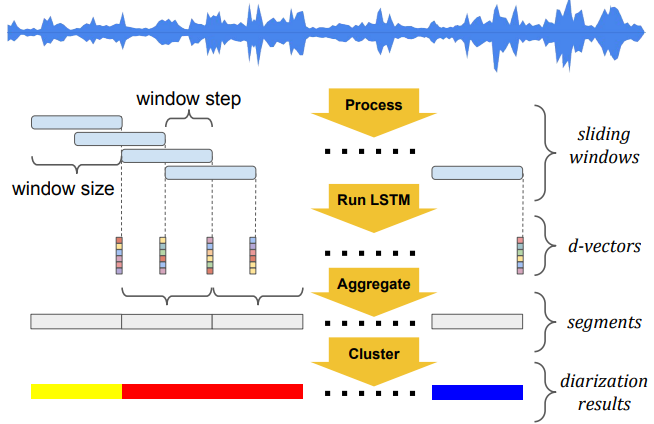

## UIS-RNN
- 대표적인 모델 Unbounded Interleaved-State Recurrent Neural Network (UIS-RNN)
    - https://github.com/google/uis-rnn
- 2019년 'Fully Supervised Speaker Diarization'란 이름으로 발표
- 'Fully'는 화자 수 추정을 포함하여 화자 분리 시스템의 모든 구성 요소가 감독되는 방식으로 교육되어 사용 가능한 레이블이 지정된 데이터의 양을 늘림으로써 이점을 얻을 수 있음을 의미
- 모든 화자의 임베딩이 매개 변수 공유 RNN (Recurrent Neural Network)에 의해 모델링되고 시간 도메인에서 인터리브 된 서로 다른 RNN 상태를 사용하여 서로 다른
화자를 구별


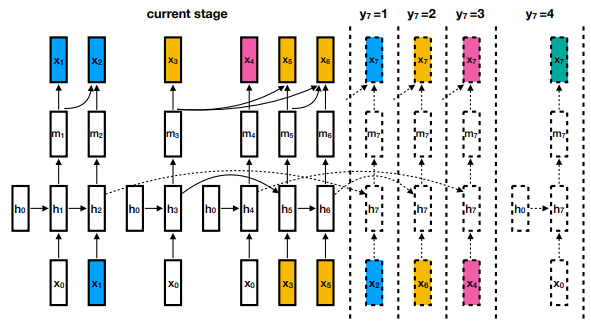

- 파란색, 노란색, 분홍색 및 녹색의 네 가지 가능한 화자가 있는 위의 예를 보면 (이는 임의적이며 실제로 더
많을 수 있다.) 
- 각 화자는 자체 RNN 인스턴스 (모든 화자간에 공유되는 공통 초기 상태)로 시작
- 이 화자의 새 임베딩이 주어지면 RNN 상태를 계속 업데이트
- 위 예에서 파란색 화자는 다른 화자인 노란색이 들어올 때까지 RNN 상태를 계속 업데이트
- 새 스피커 녹색이 입력되면 새 RNN 인스턴스로 시작

- waveform에 화자 정보를 label에 maping하기에는 상당히 어려움이 있다.
- UIS-RNN에서는 데이터 셋 제공
```
https://github.com/google/uis-rnn/blob/master/data/toy_training_data.npz?raw=True
https://github.com/google/uis-rnn/blob/master/data/toy_testing_data.npz?raw=True
```
- waveform을 Embedding은 d-vector을 이용했다고 git과 논문에 표시.   
※ d-vector 는 심층 신경망으로부터 추출된 특징

참고하여 진행
https://pypi.org/project/uisrnn/

## 라이브러리 설치


*   uisrnn을 간편하게 구현할 수 있는 uisrnn 라이브러리가 존재
*   여기서는 uisrnn 라이브러리를 통해 uisrnn을 구현하고 학습, 평가
*   실습을 위해 uisrnn과 easydict 라이브러리를 설치




In [ ]:
!pip install uisrnn easydict

## 데이터 다운로드

* 학습 및 평가에는 uisrnn 라이브러리에서 제공하는 sample dataset을 사용
* urlretrieve를 통해 url에서 데이터를 받아옴
* https://github.com/google/uis-rnn/blob/master/data/toy_training_data.npz?raw=True
* https://github.com/google/uis-rnn/blob/master/data/toy_testing_data.npz?raw=True



In [ ]:
import urllib.request

training_url = 'https://github.com/google/uis-rnn/blob/master/data/toy_training_data.npz?raw=True'
urllib.request.urlretrieve(training_url, './toy_training_data.npz')

testing_url = 'https://github.com/google/uis-rnn/blob/master/data/toy_testing_data.npz?raw=True'
urllib.request.urlretrieve(testing_url, './toy_testing_data.npz')

('./toy_testing_data.npz', <http.client.HTTPMessage at 0x7fc579c8c310>)



*   다운로드한 데이터에서 데이터를 받아오고 sequence와 label을 분리



In [ ]:
import numpy as np
import uisrnn

train_data = np.load('./toy_training_data.npz', allow_pickle=True)
test_data = np.load('./toy_testing_data.npz', allow_pickle=True)

In [ ]:
train_data.files

['train_sequence', 'train_cluster_id']

In [ ]:
test_data.files

['test_sequences', 'test_cluster_ids']

In [ ]:
train_sequence = train_data['train_sequence']
train_cluster_id = train_data['train_cluster_id']

test_sequences = test_data['test_sequences']
test_cluster_ids = test_data['test_cluster_ids']

print(train_sequence[0])

[ 1.13890201e-03  3.82177185e-02 -6.48594588e-03  9.89223027e-03
  2.46802228e-02 -7.36468230e-02  2.03830034e-01  1.03609769e-02
  2.78913034e-02 -8.29202631e-02  7.39009311e-02 -2.79328340e-02
 -6.23055992e-02 -1.47791947e-02  2.20468904e-02 -3.72584180e-02
 -3.73022909e-02  5.63643239e-02 -1.46196790e-02  1.10949987e-01
  5.04364679e-03  1.40099865e-02  1.29598757e-02 -4.43333542e-02
 -3.59590614e-02  2.20498834e-02  4.16737052e-02  7.49229353e-02
 -3.58573846e-02 -4.25351661e-02  5.25247907e-02 -4.11656415e-02
 -1.82226172e-02 -1.56861532e-02  5.64970734e-02 -2.42418862e-02
 -1.11625780e-02  7.54742372e-02 -5.10478402e-02 -3.42293490e-02
  1.46031251e-02  7.86327315e-03 -1.16638640e-01  3.91309886e-02
  2.32791874e-02  3.27887268e-02  4.13308623e-02  4.39213114e-02
 -5.47886145e-02 -5.87707558e-02 -1.85377181e-01 -1.35295973e-02
  3.29825421e-02 -5.95737140e-02 -2.20608949e-03 -1.70537428e-02
 -8.79762787e-03 -1.62059722e-02 -5.61071781e-02 -1.97304611e-02
 -2.90384742e-02 -3.11128

In [ ]:
print(train_cluster_id)

['0_0' '0_0' '0_0' ... '499_2' '499_2' '499_3']


## 파라미터 설정

*   model, training, inference에 필요한 인자들은 uisrnn.parse_argement()를 통해 얻을 수 있음
*   colab 환경에서는 argument를 사용할 수 없기 때문에 easydict로 대체



In [ ]:
# model_args, training_args, inference_args = uisrnn.parse_arguments()
import easydict
model_args = easydict.EasyDict({'observation_dim':256,
                                'rnn_hidden_size':512,
                                'rnn_depth':1,
                                'rnn_dropout':0.2,
                                'transition_bias':None,
                                'crp_alpha':1.0,
                                'sigma2':None,
                                'verbosity':2,
                                'enable_cuda':True})
training_args = easydict.EasyDict({'optimizer':'adam',
                                   'learning_rate':1e-3,
                                   'train_iteration':20000,
                                   'grad_max_norm':5.0,
                                   'batch_size':10,
                                   'num_permutations':10,
                                   'sigma_alpha':1.0,
                                   'sigma_beta':1.0,
                                   'regularization_weight':1e-5,
                                   'enforce_cluster_id_uniqueness':True})
inference_args = easydict.EasyDict({'beam_size':10,
                                    'look_ahead':1,
                                    'test_iteration':2})

In [ ]:
model_args

{'crp_alpha': 1.0,
 'enable_cuda': True,
 'observation_dim': 256,
 'rnn_depth': 1,
 'rnn_dropout': 0.2,
 'rnn_hidden_size': 512,
 'sigma2': None,
 'transition_bias': None,
 'verbosity': 2}

## UISRNN 모델 학습



*   앞서 구성한 argment를 사용해 모델을 구성
*   데이터를 입력해 모델을 훈련



In [ ]:
model = uisrnn.UISRNN(model_args)

model.fit(train_sequence, train_cluster_id, training_args)

Iter: 0  	Training Loss: -284.8341    
    Negative Log Likelihood: 5.9046	Sigma2 Prior: -290.7393	Regularization: 0.0006
Iter: 10  	Training Loss: -298.7359    
    Negative Log Likelihood: 5.6295	Sigma2 Prior: -304.3660	Regularization: 0.0006
Iter: 20  	Training Loss: -313.1901    
    Negative Log Likelihood: 6.2672	Sigma2 Prior: -319.4580	Regularization: 0.0006
Iter: 30  	Training Loss: -329.7880    
    Negative Log Likelihood: 7.1077	Sigma2 Prior: -336.8963	Regularization: 0.0006
Iter: 40  	Training Loss: -347.8880    
    Negative Log Likelihood: 8.3234	Sigma2 Prior: -356.2120	Regularization: 0.0006
Iter: 50  	Training Loss: -373.7039    
    Negative Log Likelihood: 10.3555	Sigma2 Prior: -384.0601	Regularization: 0.0007
Iter: 60  	Training Loss: -402.9857    
    Negative Log Likelihood: 13.6331	Sigma2 Prior: -416.6194	Regularization: 0.0007
Iter: 70  	Training Loss: -438.7320    
    Negative Log Likelihood: 22.8506	Sigma2 Prior: -461.5833	Regularization: 0.0007
Iter: 80  	Tra

## 모델 평가



*   평가 데이터를 사용해 각 sequence에 해당하는 화자 id를 얻음



In [ ]:
test_sequences.shape

(25,)

In [ ]:
predicted_cluster_ids = model.predict(test_sequences[0], inference_args)

In [ ]:
predicted_cluster_ids=[]
test_record = []

for(test_sequence, test_cluster_id) in zip(test_sequences.tolist(),test_cluster_ids.tolist()):
    predicted_cluster_id = model.predict(test_sequence, inference_args)
    predicted_cluster_ids.append(predicted_cluster_id)
    acc = uisrnn.compute_sequence_match_accuracy(test_cluster_id,predicted_cluster_id)
    test_record.append(acc)
    print(f'예측 값:{predicted_cluster_id}')
    print(f'실제 값:{test_cluster_id}')
    print('-'*150)

예측 값:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
실제 값:['15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_0', '15_0', '15_0', '15_0', '15_0', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_1', '15_1',

In [ ]:
print(test_record)

[0.6526315789473685, 1.0, 0.43617021276595747, 1.0, 0.5865384615384616, 0.7093023255813954, 0.6979166666666666, 0.9900990099009901, 0.47058823529411764, 0.574468085106383, 0.3829787234042553, 0.3979591836734694, 0.6888888888888889, 1.0, 0.36585365853658536, 0.5462184873949579, 0.6355140186915887, 0.06382978723404255, 1.0, 0.48484848484848486, 0.6290322580645161, 1.0, 0.968, 0.9207920792079208, 0.33707865168539325]
